In [ ]:
import pandas as pd
import numpy as np

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 13.2 MB/s 
     |████████████████████████████████| 9.9 MB 63.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize']=10,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import statsmodels.api as sm
import json

In [ ]:
data=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TSLA.xlsx',index_col=0,engine='openpyxl')

#dropping the null and undefined format
a='%Y-%m-%d %H:%M:%S'
data.time=pd.to_datetime(data.time,format=a,errors='coerce')
data=data[data['time'].notna()]

In [ ]:
data

,time,open,high,low,close,volume
0,2021-08-20 20:00:00,680.2,680.3,680.0,680.3,1357
1,2021-08-20 19:55:00,680.1,680.2,680.1,680.12,1247
2,2021-08-20 19:50:00,679.9,680.0,679.9,680.0,1039
3,2021-08-20 19:45:00,679.9,679.9,679.8,679.8,1444
4,2021-08-20 19:40:00,679.9999,680.0,679.9999,680.0,590
...,...,...,...,...,...,...
45017,2020-08-28 04:50:00,453.602,453.602,453.54,453.54,2855
45018,2020-08-28 04:35:00,454.012,454.012,454.0,454.0,3715
45019,2020-08-28 04:25:00,453.558,453.558,453.558,453.558,1370
45020,2020-08-28 04:10:00,452.0,452.0,452.0,452.0,1855


In [ ]:
data=data[::-1].reset_index(drop=True)
data

,time,open,high,low,close,volume
0,2020-08-28 04:05:00,451.998,451.998,451.998,451.998,2820
1,2020-08-28 04:10:00,452.0,452.0,452.0,452.0,1855
2,2020-08-28 04:25:00,453.558,453.558,453.558,453.558,1370
3,2020-08-28 04:35:00,454.012,454.012,454.0,454.0,3715
4,2020-08-28 04:50:00,453.602,453.602,453.54,453.54,2855
...,...,...,...,...,...,...
45006,2021-08-20 19:40:00,679.9999,680.0,679.9999,680.0,590
45007,2021-08-20 19:45:00,679.9,679.9,679.8,679.8,1444
45008,2021-08-20 19:50:00,679.9,680.0,679.9,680.0,1039
45009,2021-08-20 19:55:00,680.1,680.2,680.1,680.12,1247


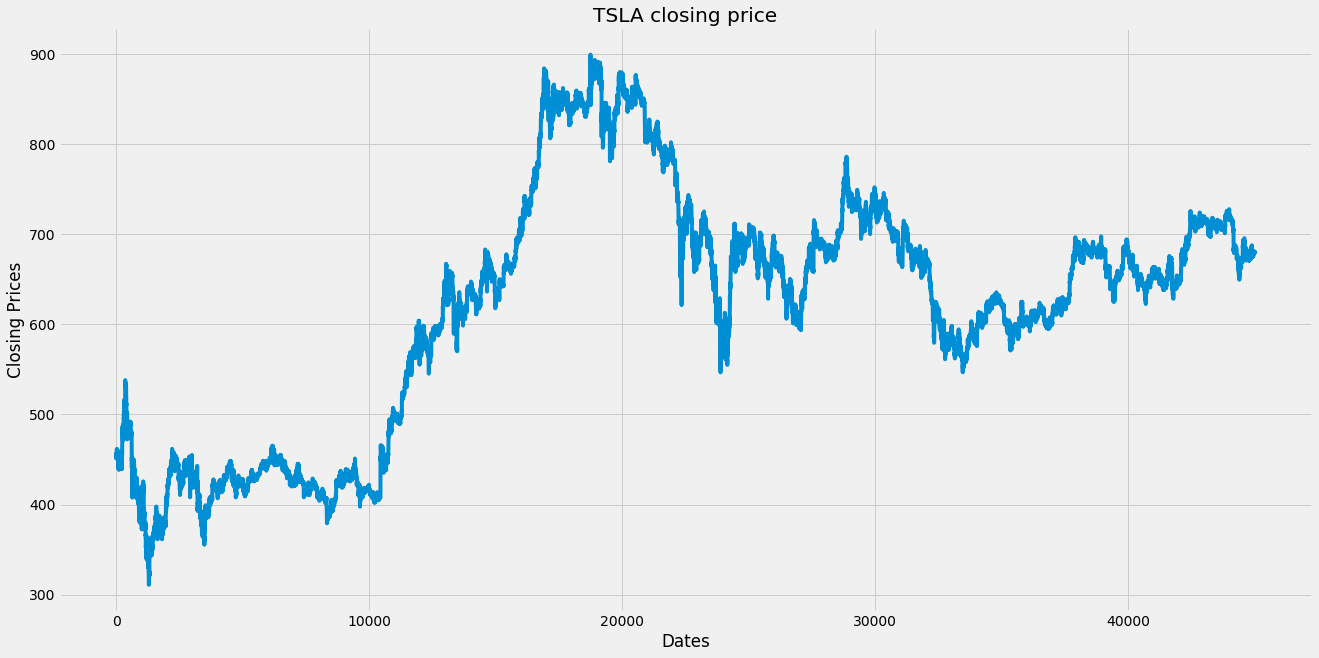

In [ ]:
#plot close price
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(pd.to_numeric(data['close']))
plt.title('TSLA closing price')
plt.show()

In [ ]:
data['close']

0        451.998
1          452.0
2        453.558
3          454.0
4         453.54
          ...   
45006      680.0
45007      679.8
45008      680.0
45009     680.12
45010      680.3
Name: close, Length: 45011, dtype: object

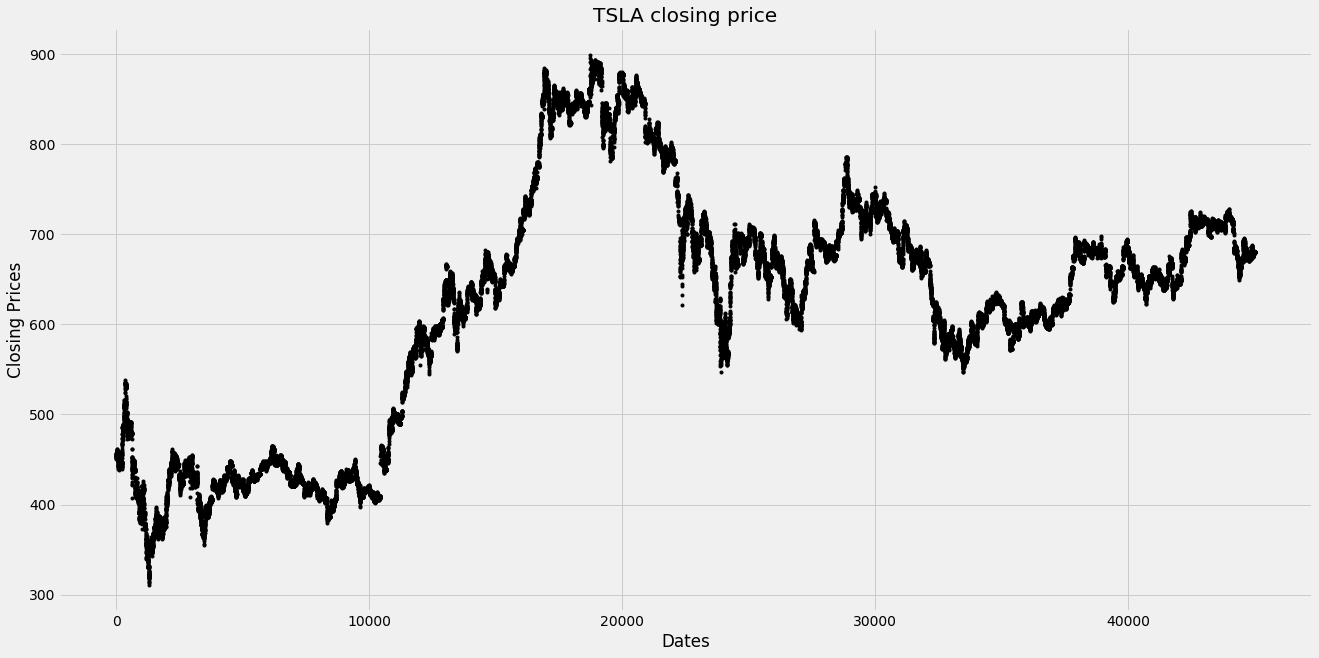

In [ ]:
#plot close price scatter plot
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
df_close=pd.to_numeric(data['close'])
df_close.plot(style='k.')

plt.title('TSLA closing price')
plt.show()

In [ ]:
#change to proper data type
data[['open','high','low','close','volume']]=data[['open','high','low','close','volume']].apply(pd.to_numeric)

In [ ]:
data.describe()

,open,high,low,close,volume
count,45011.000000,45011.000000,45011.000000,45011.000000,4.501100e+04
mean,620.587077,621.572895,619.609182,620.578186,2.057779e+05
std,133.283713,133.324143,133.236525,133.284905,3.567299e+05
min,310.580000,313.850000,308.000000,311.000000,1.000000e+02
25%,516.050000,518.000000,513.850000,516.145150,4.537000e+03
50%,646.298000,647.390000,645.330000,646.250000,3.642100e+04
75%,699.885000,701.000000,698.760000,699.860000,2.818310e+05
max,899.445000,900.400000,892.400000,899.290100,8.516154e+06


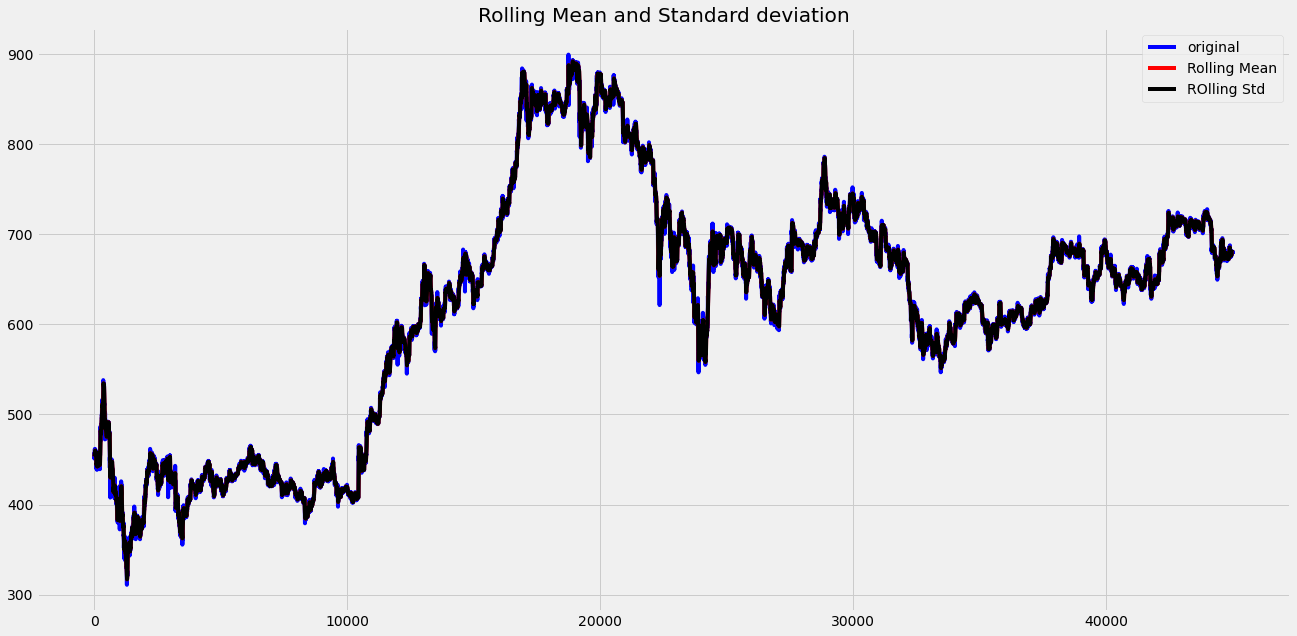

Results of dickey fuller test
Test Statistics                   -1.550962
p-value                            0.508167
No. of lags used                  30.000000
Number of observations used    44980.000000
critical value(1%)                -3.430495
critical value(5%)                -2.861604
critical value(10%)               -2.566804
dtype: float64
----------------------------------------------------------------------------------------------------
weak evidence against the null hypothesis,time series has a unit root,indicating it is non-stationary 


In [ ]:
#Test for stationarity
#Ho:It is non stationary
#h1:It is stationary
def test_stationarity(timeseries):
  #Determining rolling statistics
  rolmean=timeseries.rolling(12).mean()
  rolstd=timeseries.rolling(12).mean()

  #plot rolling statistics
  plt.figure(figsize=(20,10))
  plt.plot(timeseries,color='blue',label='original')
  plt.plot(rolmean,color='red',label='Rolling Mean')
  plt.plot(rolmean,color='black',label='ROlling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard deviation')
  plt.show(block=False)

  print('Results of dickey fuller test')
  adft=adfuller(timeseries,autolag='AIC')

  #output for dft will give is without defining what the values are
  #hence we manually wriite what values does it explains using a for loop
  output=pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
  for key,values in adft[4].items():
    output['critical value(%s)'%key]=values
  print(output)
  print('-'*100)
  if output['p-value']<=0.05:
    print("strong evidence against the null hypothesis(H0),reject the null hypothesis. Data has no unit root and is stationary")
  else:
    print("weak evidence against the null hypothesis,time series has a unit root,indicating it is non-stationary ")
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

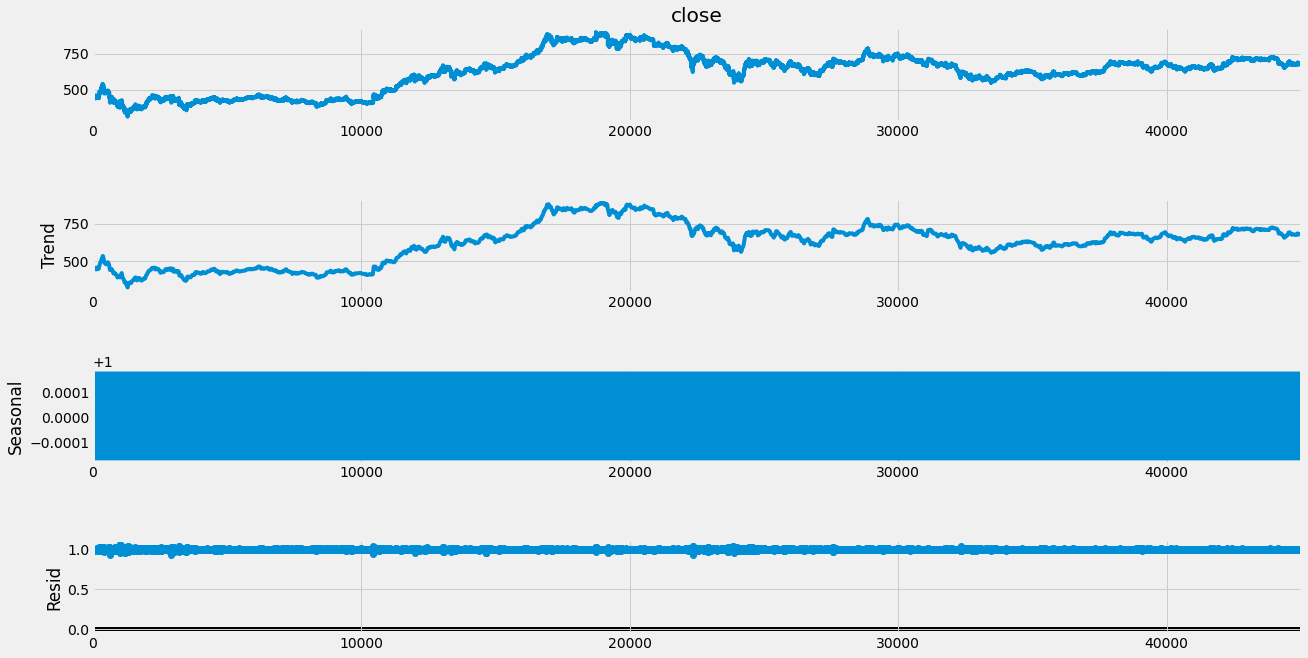

In [ ]:
result=seasonal_decompose(df_close,model='multuplicative',period=30)
fig=plt.figure()
fig=result.plot()
fig.set_size_inches(20,10)

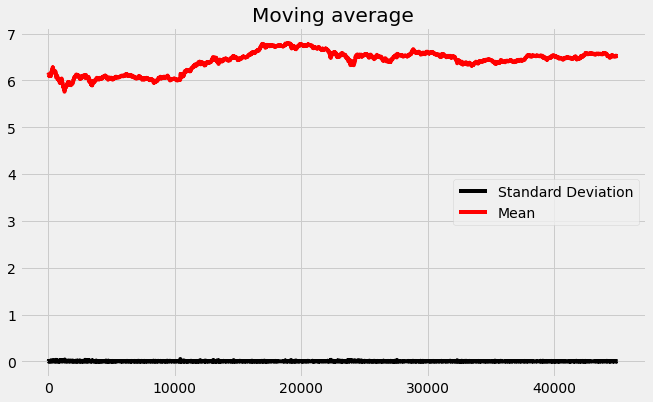

In [ ]:
rcParams['figure.figsize']=10,6
df_log=np.log(df_close)
moving_avg=df_log.rolling(12).mean()
std_dev=df_log.rolling(12).std()
plt.title('Moving average')
plt.plot(std_dev,color='black',label='Standard Deviation')
plt.plot(moving_avg,color='red',label='Mean')
plt.legend()
plt.show()

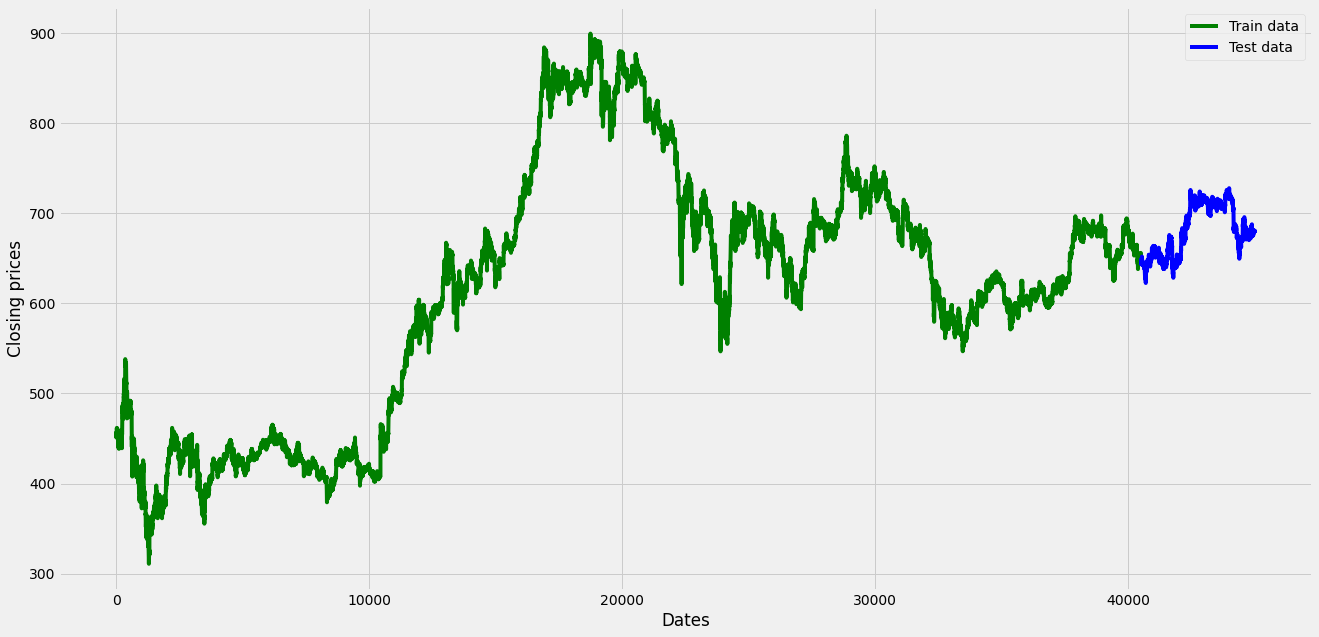

In [ ]:
#split the data into train and test
train_data,test_data=df_close[:int(len(df_close)*0.9)],df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing prices')
plt.plot(train_data,'green',label='Train data')
plt.plot(test_data,'blue',label='Test data')
plt.legend()



In [ ]:
complete_data=df_close
complete_data

0        451.998
1        452.000
2        453.558
3        454.000
4        453.540
          ...   
45006    680.000
45007    679.800
45008    680.000
45009    680.120
45010    680.300
Name: close, Length: 45011, dtype: float64

In [ ]:
test_data

40509    644.590
40510    645.030
40511    647.460
40512    649.160
40513    648.708
          ...   
45006    680.000
45007    679.800
45008    680.000
45009    680.120
45010    680.300
Name: close, Length: 4502, dtype: float64

In [ ]:
model_autoARIMA =auto_arima(complete_data,start_p=0,start_q=0,
                            test='adf', #use adftest to find optimal 'd
                            max_p=3,max_q=3, #maximum p and q
                            m=1,
                            d=None,
                            seasonal=False,
                            start_P=0,
                            D=0,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True
                            )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=183501.887, Time=1.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=183422.854, Time=3.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=183419.965, Time=4.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=183500.222, Time=0.94 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=183416.957, Time=11.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=183401.743, Time=47.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=183408.540, Time=5.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=183390.977, Time=23.73 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=183393.490, Time=5.87 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=183381.723, Time=74.64 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=183379.729, Time=45.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=183403.320, Time=23.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=183381.726, Time=64.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=183389.683, Time=26.01 s

In [ ]:
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                45011
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -91684.043
Date:                Sun, 01 Jan 2023   AIC                         183378.086
Time:                        14:00:03   BIC                         183421.659
Sample:                             0   HQIC                        183391.802
                              - 45011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7007      0.049     14.402      0.000       0.605       0.796
ar.L2         -0.5951      0.031    -19.126      0.000      -0.656      -0.534
ma.L1         -0.7439      0.049    -15.290      0.0

In [ ]:
model_info=model_autoARIMA.to_dict()
for key,value in model_info.items():
  if isinstance(value,pd.Series):
    model_info[key]=value.to_list()
model_info_json=json.dumps(model_info)

with open('ARIMA_model_TSLA.json','w') as fp:
          fp.write(model_info_json)
with open('ARIMA_model_TSLA.json','r') as fp:
  file=json.load(fp)
order=tuple(file['order'])

In [ ]:
order

(2, 1, 2)

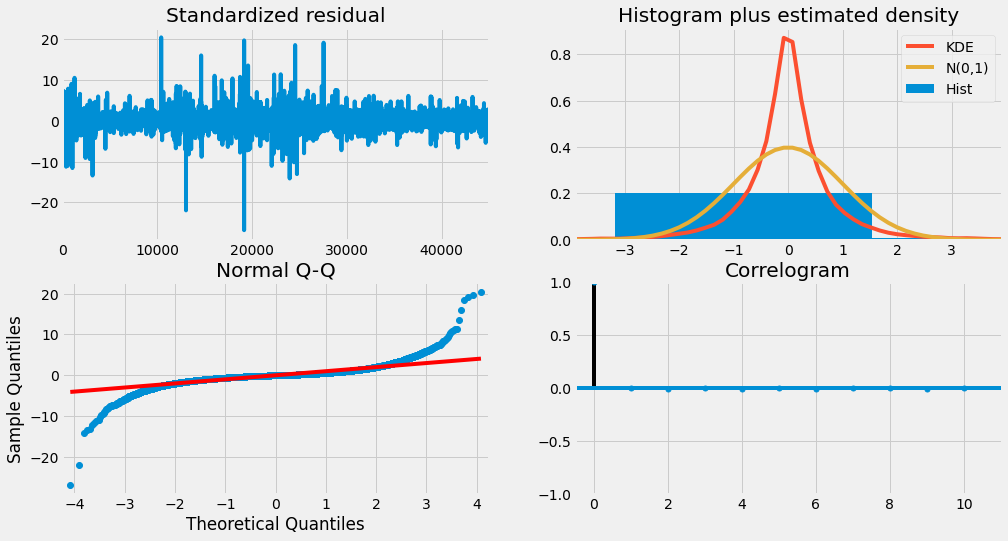

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model=ARIMA(train_data,order=order)
#from statmodels.tsa impport SARIMAX
#model =SARIMAX(complete_data,order=order,easibal_order=seasonal_order)
fitted=model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                40509
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -83737.125
Date:                Sun, 01 Jan 2023   AIC                         167484.249
Time:                        14:00:25   BIC                         167527.296
Sample:                             0   HQIC                        167497.867
                              - 40509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7086      0.052     13.585      0.000       0.606       0.811
ar.L2         -0.5873      0.033    -17.539      0.000      -0.653      -0.522
ma.L1         -0.7523      0.052    -14.429      0.0

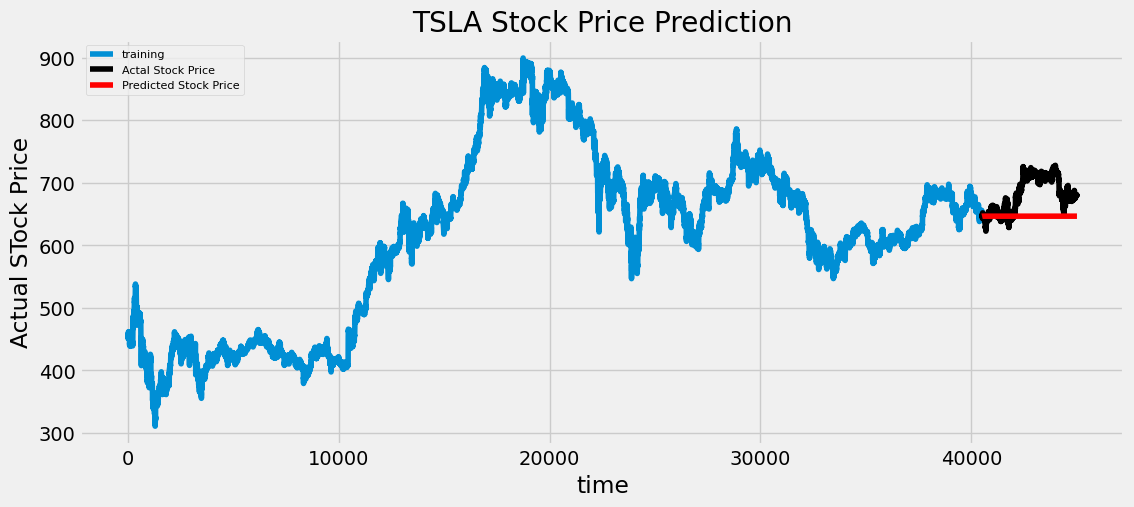

In [ ]:
#Forecast
fc=fitted.forecast(len(test_data),alpha=0.05) #95% confidence 4502 is len of test data

#se=forecas[1]
#conf=forecats[2]

fc_series = pd.Series(fc,index=test_data.index)

#lower_series = pd.Series(conf[:,0,index=test_data.index])
#upper_series = pd.Series(conf[:,1,index=test_data.index])
plt.figure(figsize=(12,5),dpi=100)
plt.plot(train_data,label='training')
plt.plot(test_data,color='black',label='Actal Stock Price')
plt.plot(fc_series,color='red',label='Predicted Stock Price')
#plt.fill_betwwen(lower_serues.indexmloqwe_series,upper_series,color='k,alpha=.10

plt.title('TSLA Stock Price Prediction')
plt.xlabel('time')
plt.ylabel('Actual STock Price')
plt.legend(loc='upper left',fontsize=8)
plt.show()

In [ ]:
test_data.shape

(4502,)

In [ ]:
train_data.shape

(40509,)

In [ ]:
df_close.shape

(45011,)

In [ ]:
#report_performanxe
mse=mean_squared_error(test_data,fc)
print('MSE:'+str(mse))

mae=mean_absolute_error(test_data,fc)
print('MAE'+str(mae))

rmse=math.sqrt(mean_squared_error(test_data,fc))
print('RMSE:'+str(rmse))

mape=np.mean(np.abs(fc-test_data)/np.abs(test_data))
print('MAPE:'+str(mape))

MSE:1996.4337135809149
MAE36.239045844004515
RMSE:44.681469465326614
MAPE:0.0517214174011625


In [ ]:
model=ARIMA(complete_data,order=order)
#from statmodels.tsa impport SARIMAX
#model =SARIMAX(complete_data,order=order,easibal_order=seasonal_order)
fitted=model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                45011
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -91684.043
Date:                Sun, 01 Jan 2023   AIC                         183378.086
Time:                        14:00:41   BIC                         183421.659
Sample:                             0   HQIC                        183391.802
                              - 45011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7007      0.049     14.402      0.000       0.605       0.796
ar.L2         -0.5951      0.031    -19.126      0.000      -0.656      -0.534
ma.L1         -0.7439      0.049    -15.290      0.0

In [ ]:
fitted.save('TSLA_Arima_model.pkl')

In [ ]:
loaded_model=ARIMAResults.load('TSLA_Arima_model.pkl')

In [ ]:
fc=loaded_model.forecast(steps=1000)

45011    680.292670
45012    680.295590
45013    680.301998
45014    680.304750
45015    680.302866
            ...    
46006    680.300812
46007    680.300812
46008    680.300812
46009    680.300812
46010    680.300812
Name: predicted_mean, Length: 1000, dtype: float64


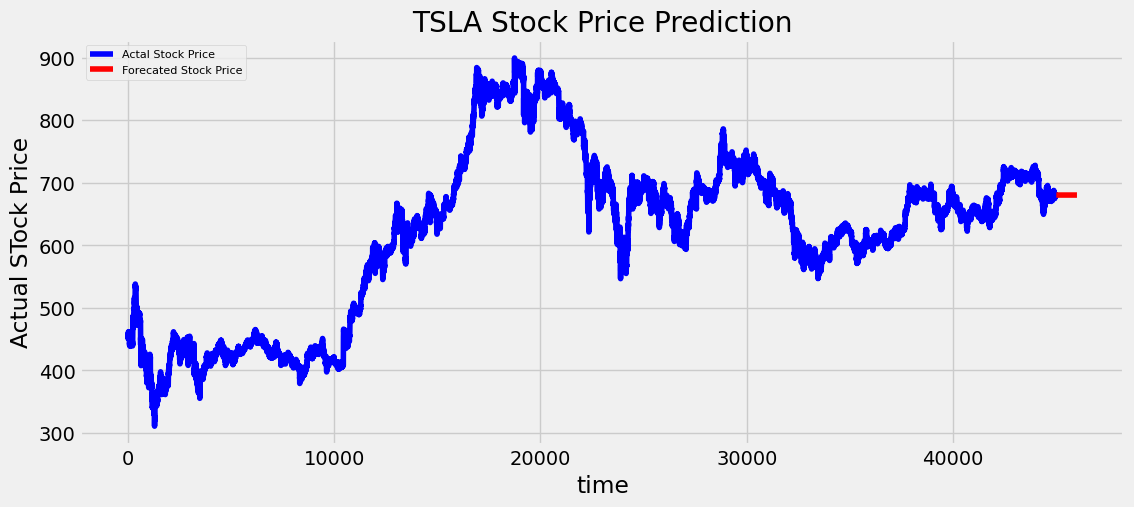

In [ ]:
fc_series=pd.Series(fc)
print(fc_series)

plt.figure(figsize=(12,5),dpi=100)
plt.plot(complete_data,color='blue',label='Actal Stock Price')
plt.plot(fc_series,color='red',label='Forecated Stock Price')

plt.title('TSLA Stock Price Prediction')
plt.xlabel('time')
plt.ylabel('Actual STock Price')
plt.legend(loc='upper left',fontsize=8)
plt.show()
